# Analyze synthetic gap experiments
### Includes 
* Aggregate median error heatmaps
* Individual median error heatmaps
* Example imputation experiment trace


### Data from

* /n/home02/daldarondo/LabDir/Diego/data/JDM27/20171207/models/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM25/20170917/models/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM25/20170919/models/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM25/20170916/models/stride_5/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM32/20171023/models/stride_5/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM31_imputation_test/models/model_ensemble/viz/analyze_6_3_19/errors.mat
* /n/home02/daldarondo/LabDir/Diego/data/JDM33/20171125/models/model_ensemble/viz/analyze_6_3_19/errors.mat


In [1]:
import numpy as np
from scipy.io import loadmat
import os
import h5py
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [2]:
# Find all of the files that completed. 
def find_files(base_path, key):
    return [f for f in Path(base_path).glob('**/' + key)]

base_path = '/n/home02/daldarondo/LabDir/Diego/data'
files = find_files(base_path, 'analyze_6_3_19/errors.mat')

# Load the data
data = [loadmat(f) for f in files]

## Find the median error at the mid-gap in sythetically generated gaps

In [3]:
def get_midgap(data):
    midgap = np.floor(data.shape[1]/2).astype('int32')
    return np.squeeze(data[:, midgap, :])

# Get data for all individuals
n_lengths = data[0]['delta_markers'].size
ind_median_error = [None] * len(files)
for i, d in enumerate(data):
    error = [get_midgap(d['delta_markers'][0, length]) for length in range(n_lengths)]
    ind_median_error[i] = [np.nanmedian(e, axis=0) for e in error]
    ind_median_error[i] = np.stack(ind_median_error[i],axis=1)

# Get data for aggregate
agg_median_error = [None] * n_lengths
for i, length in enumerate(range(n_lengths)):
    error = [get_midgap(d['delta_markers'][0, length]) for d in data]
    agg_median_error[i] = np.nanmedian(np.concatenate(error, axis=0), axis=0)

agg_median_error = np.stack(agg_median_error, axis=1)

## Plot aggregate data as a heat map

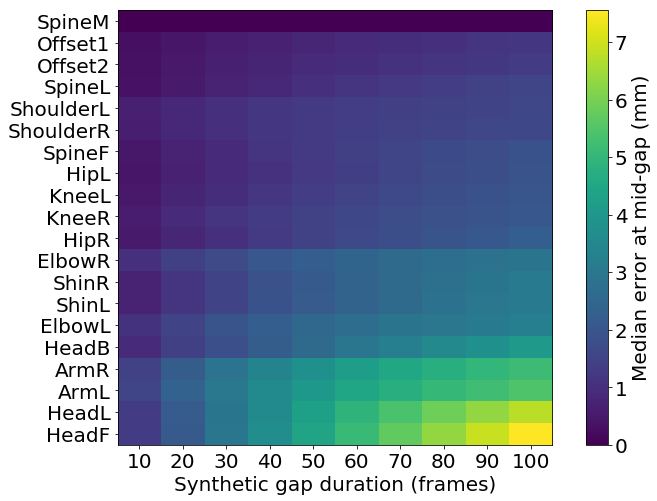

In [6]:
f, ax = plt.subplots(figsize=(12,8))
kp_names = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM',
            'SpineL', 'Offset1', 'Offset2', 'HipL', 'HipR',
            'ElbowL', 'ArmL', 'ShoulderL', 'ShoulderR',
            'ElbowR', 'ArmR', 'KneeR', 'KneeL', 'ShinL', 'ShinR']

def delta_heatmap(data, ax):
    n_lengths = data.shape[1]
    inds = np.argsort(data[:,-1])
    plt.imshow(data[inds, :],aspect=.5)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels([kp_names[i] for i in inds])
    ax.set_xticks(range(n_lengths))
    ax.set_xticklabels([i*10 for i in range(1, n_lengths+1)])
    ax.set_xlabel('Synthetic gap duration (frames)')
    c = plt.colorbar()
    c.ax.set_ylabel('Median error at mid-gap (mm)')
    plt.rcParams['font.size'] = 20
    
delta_heatmap(agg_median_error, ax)

# Make the same plot for each individual

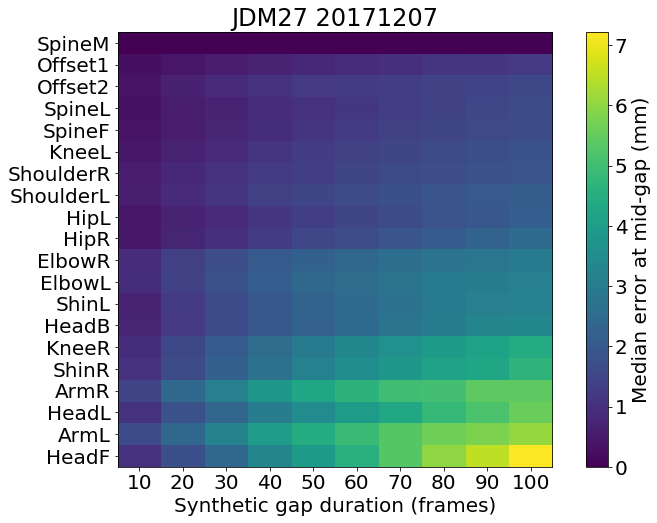

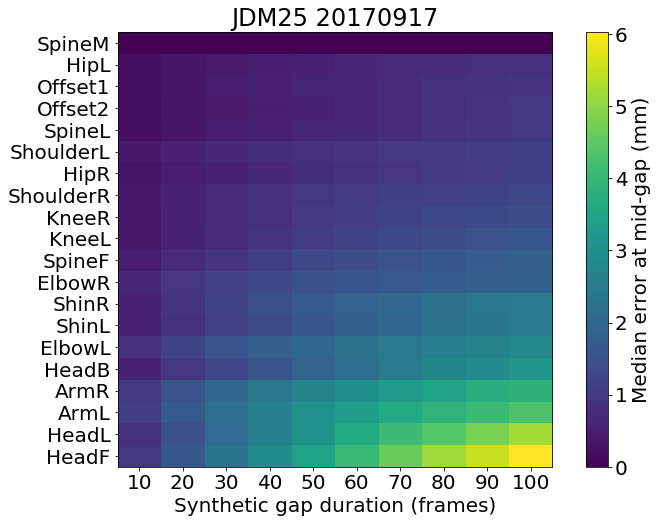

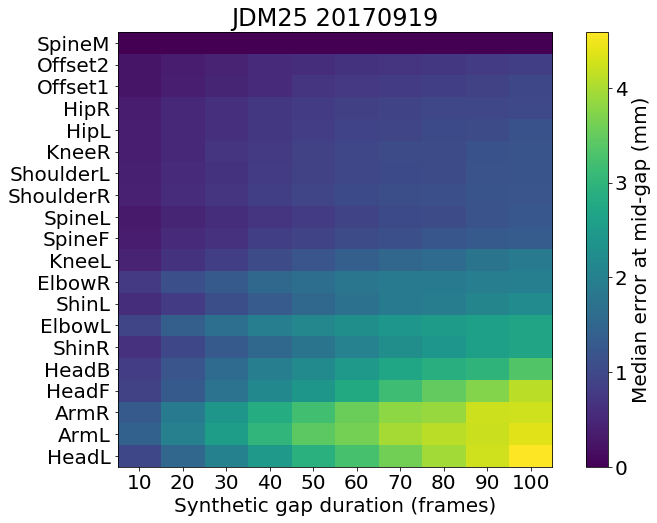

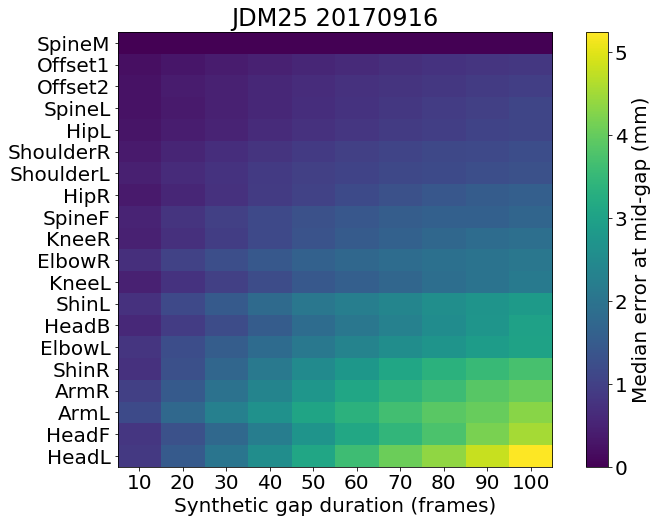

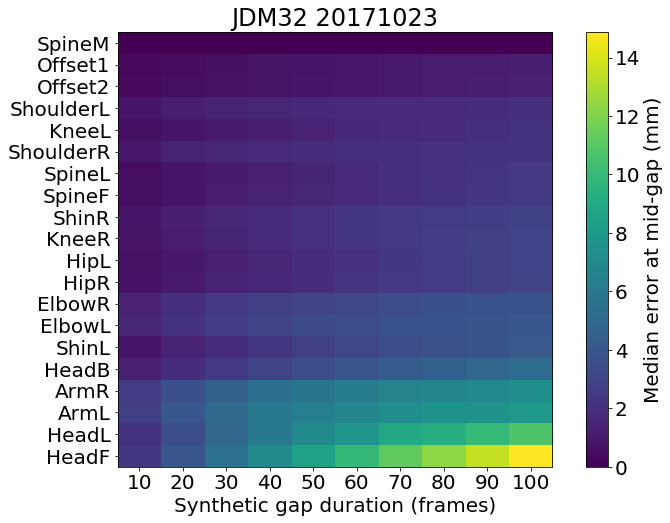

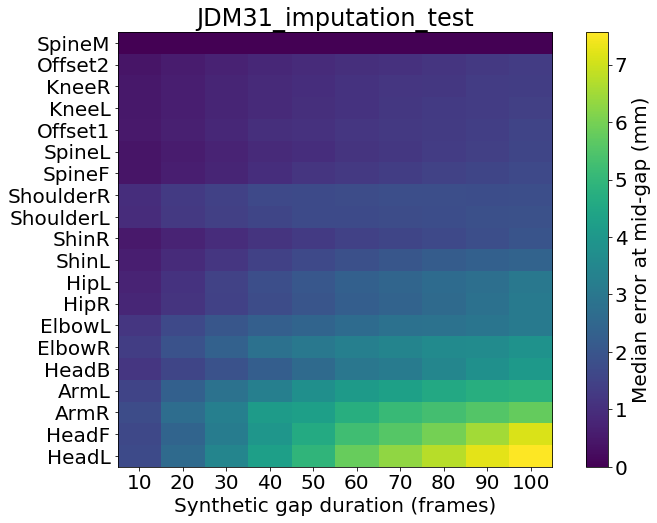

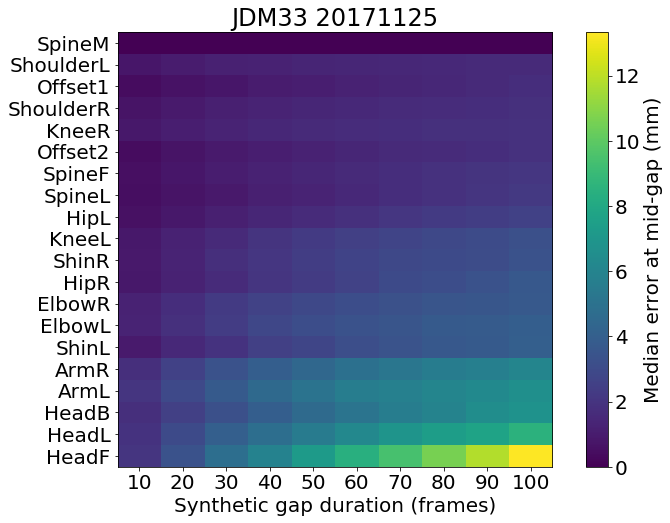

In [5]:
ind_median_error[0].shape
for i, f in enumerate(files):
    fig, ax = plt.subplots(figsize=(12,8))
    delta_heatmap(ind_median_error[i], ax)
    rat_name = re.findall('JDM.*/*/', str(f))
    rat_name = re.sub('/models/.*', '', rat_name[0]) 
    rat_name =  re.sub('/', ' ', rat_name)
    ax.set_title(rat_name)